**Author**: Lulof Pirée

**Date**: May 2022

--------------------------------------------------------------------------------
Copyright (C) 2022 Lulof Pirée

This file is part of the snakes_spn program.

This program is free software:
you can redistribute it and/or modify it under the terms
of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.
If not, see <https://www.gnu.org/licenses/>.

--------------------------------------------------------------------------------
## File content
Small investigation in the distribution of amount of attracted
neutrophils under different conditions.
The main question is whether this is approximately normally
distributed between different runs.
In case it is, it would be possible to use the $t$-test
to compare different parameter setters.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy import stats

from spn_case_study.launch_experiment import (
    setup_init_markings_all_choices, setup_rates_all_choices)
from spn_case_study.run_grid_search import run_experiment
from spn_case_study.petrinet import PLACES, VARS, TRANS, TRANS_TO_PLACES
from spn_tools.run_simulation import (plot_results, load_log,
    aggregate_dataset_in_timeboxes)
import numpy as np



# Notebooks usually set the cwd to the directory containing the notebook itself.
print(f"Current directory: {os.getcwd()}")
if "neutrophil_normality.ipynb" in os.listdir(os.getcwd()):
    SAVE_DIR = os.path.join(os.getcwd(), "neutrophil_normality_data")
else:
    raise RuntimeError("Wrong working directory.")

NUM_REPETITIONS = 200
MAX_NUM_TRANSITIONS = 500
MAX_TIME_PASSED = 5

Current directory: /home/nifrec/Vault/Documents/master_1/bio_modelling/model_ass/snakes_spn/spn_case_study


## Run 1: no inhibition.
That is, $[Gr^*] = 0$ at all time.

In [2]:
RUN_1_SAVE_DIR = os.path.join(SAVE_DIR, "unrepressed")
init_markings = {name: (0,) for name in PLACES}
init_markings["neutrophil_free"] = (200,)
init_markings["infl_sig"] = (200,)

rates = {name : "0" for name in TRANS}
rates["recruit_neutrophil"] = f"{VARS['infl_sig']}" 

# Filename of the json gets automatically added by `run_experiment()`,
# but we don't want to run the experiment if the data already exists.
log_filename = os.path.join(RUN_1_SAVE_DIR, "logs.json")
if not os.path.exists(log_filename):
    run_experiment(rates, init_markings, RUN_1_SAVE_DIR, NUM_REPETITIONS, 
                   max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)
else:
    print("Experiment data already present -- loading existing data.")
log = load_log(log_filename)

Experiment data already present -- loading existing data.


[(0.0, 0.8), Text(0, 0.5, 'Neutrophil concentration')]

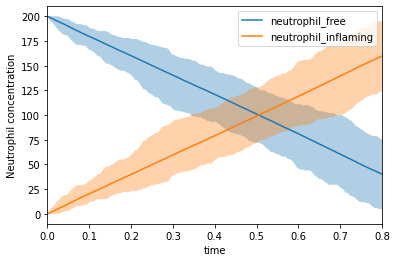

In [3]:
num_timeboxes = MAX_NUM_TRANSITIONS//2
x_var = "time"
y_vars = ["neutrophil_free", "neutrophil_inflaming"]
ax = plot_results(log, x_var, y_vars, 
             num_timeboxes, interval_type="min_max")
ax.set(xlim = [0, 0.8], ylabel="Neutrophil concentration")

From the plot, it seems that the time $t = 0.7$ is a good moment to test
for normality.

In [4]:
aggregated_data, timebox_duration = aggregate_dataset_in_timeboxes(log, x_var, y_vars, 
                                                 num_timeboxes)
desired_timestamp = 0.7
desired_index = round(0.7/timebox_duration)

num_recruited = [run_values[desired_index] for run_values in aggregated_data["neutrophil_inflaming"]]
num_free = [run_values[desired_index] for run_values in aggregated_data["neutrophil_free"]]

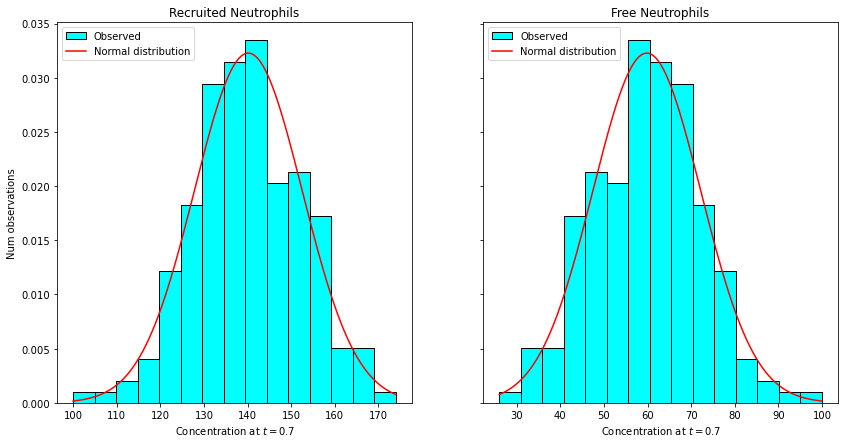

In [5]:
def plot_normal_distr(data:float, ax: Axes):
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    xlims = [min(data), max(data)]
    x_values = np.linspace(*xlims, num=1000)
    pdf_values =  [stats.norm.pdf(x, loc=mean, scale=std) for x in x_values]
    ax.plot(x_values, pdf_values, color="red", label="Normal distribution")

def plot_histograms(num_recruited, num_free):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7), sharey=True)

        ax = axes[0]
        ax.hist(num_recruited, density=True, edgecolor = "black", facecolor="cyan", 
                bins=15, label="Observed")
        plot_normal_distr(num_recruited, ax)
        ax.set_title("Recruited Neutrophils")
        ax.set_ylabel("Num observations")
        ax.set_xlabel("Concentration at $t=0.7$")
        ax.legend(loc="upper left")

        ax = axes[1]
        ax.hist(num_free, density=True, edgecolor = "black", facecolor="cyan", 
                bins=15, label="Observed")
        ax.set_title("Free Neutrophils")
        ax.set_xlabel("Concentration at $t=0.7$")
        plot_normal_distr(num_free, ax)
        ax.legend(loc="upper left");
plot_histograms(num_recruited, num_free)



The transition in the SPN removes one free neutrophil 
and adds one recruited neutrophil, so it is only to be expected
that the plots are all mirrored versions of each other.

It isn't very clear if this distribution is normal.
Let's use a statistical test!

ShapiroResult(statistic=0.9960057735443115, pvalue=0.8832067847251892)


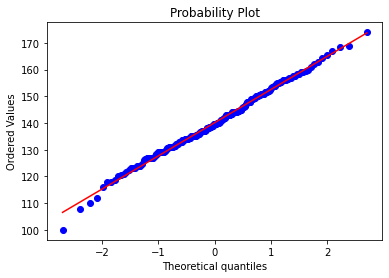

In [6]:
print(stats.shapiro(num_recruited))
stats.probplot(num_recruited, plot=plt);

## Run 2: decreasing recruitment rate
Start with a high concentration of Gr and Pdn.
The rate of neutrophil recruitment will now decrease with time,
so the distribution of amounts between runs might not be normal anymore.

In [7]:
RUN_2_SAVE_DIR = os.path.join(SAVE_DIR, "repressed")

init_markings["gr_free"] = (100,)
init_markings["pdn"] = (100,)

rates["bind_pdn"] = f"{VARS['pdn']}*{VARS['gr_free']}"
rates["unbind_pdn"] = f"{VARS['gr_pdn']}"
rates["repress_infl"] = f"{VARS['gr_pdn']}"
print(rates)

log_filename = os.path.join(RUN_2_SAVE_DIR, "logs.json")
if not os.path.exists(log_filename):
    run_experiment(rates, init_markings, RUN_2_SAVE_DIR, NUM_REPETITIONS, 
                   max_steps=MAX_NUM_TRANSITIONS, max_time=MAX_TIME_PASSED)
else:
    print("Experiment data already present -- loading existing data.")
log = load_log(log_filename)

{'decay_gba2': '0', 'cleave': '0', 'decay_pdn': '0', 'bind_pdn': 'c_pdn*c_gr_free', 'unbind_pdn': 'c_gr_pdn', 'decay_gbpdn': '0', 'bind_gbpdn': '0', 'unbind_gbpdn': '0', 'recruit_neutrophil': 'c_infl_sig', 'repress_infl': 'c_gr_pdn'}
Experiment data already present -- loading existing data.


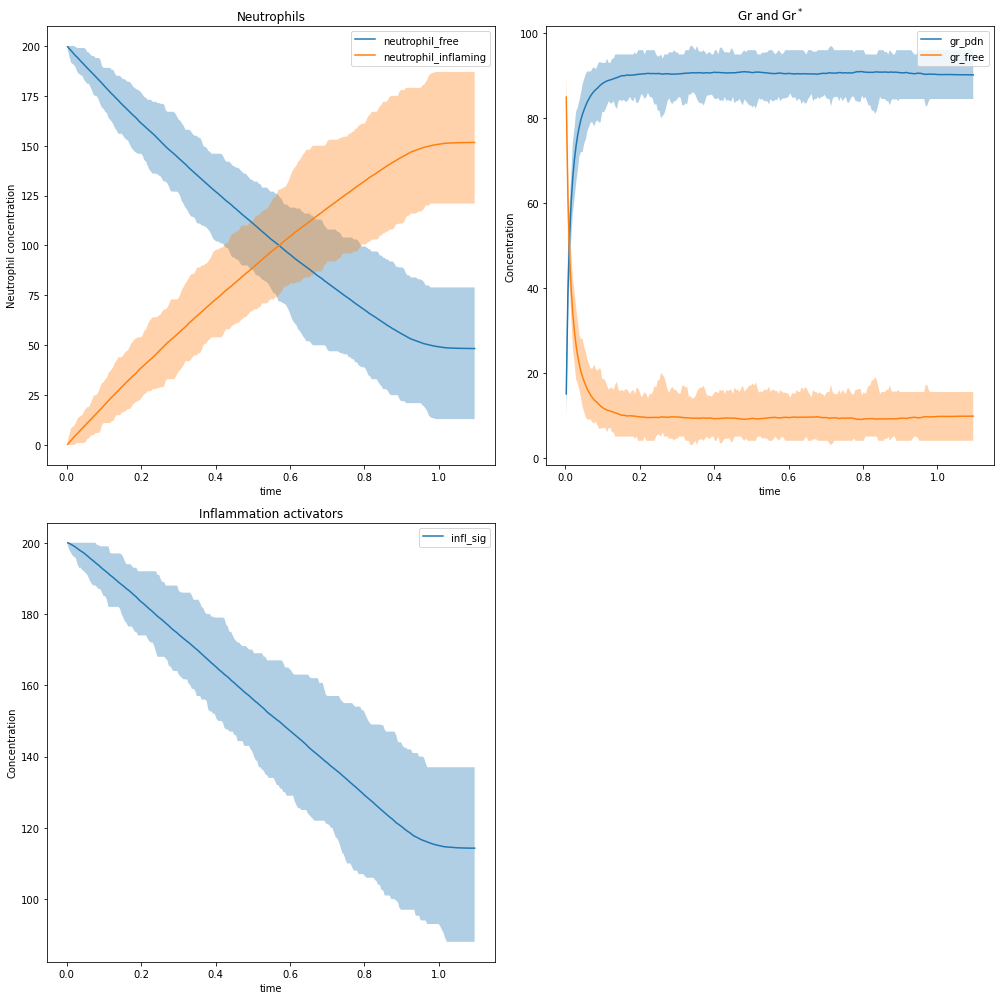

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
ax = axes[0, 0]
plot_results(log, x_var, y_vars, 
             num_timeboxes, interval_type="min_max", ax = ax)
ax.set(ylabel="Neutrophil concentration", title="Neutrophils")

ax = axes[0, 1]
plot_results(log, x_var, ["gr_pdn", "gr_free"], num_timeboxes, 
             interval_type="min_max", ax = ax)
ax.set(ylabel="Concentration", title="Gr and Gr$^*$")

ax = axes[1, 0]
plot_results(log, x_var, ["infl_sig"], num_timeboxes, 
             interval_type="min_max", ax = ax)
ax.set(ylabel="Concentration", title="Inflammation activators")

axes[1, 1].remove()
plt.tight_layout()


The inhibition shows off. Especially after $t=1.0$ the repression becomes strong.
This is caused by the low concentration of `infl_sig` 
(inflammation signal / neutrophil attractors).

Again the timestamp $t = 0.7$ seems a good point,
so lets repeat exactly the same data analysis as for the constant recruitment rate.

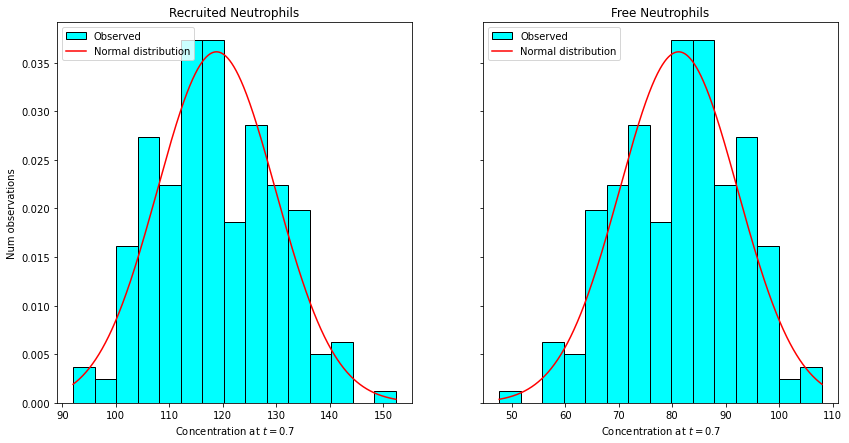

In [9]:
aggregated_data, timebox_duration = aggregate_dataset_in_timeboxes(log, x_var, y_vars, 
                                                 num_timeboxes)
desired_timestamp = 0.7
desired_index = round(0.7/timebox_duration)

num_recruited = [run_values[desired_index] for run_values in aggregated_data["neutrophil_inflaming"]]
num_free = [run_values[desired_index] for run_values in aggregated_data["neutrophil_free"]]
plot_histograms(num_recruited, num_free)

ShapiroResult(statistic=0.9923912286758423, pvalue=0.3852907717227936)


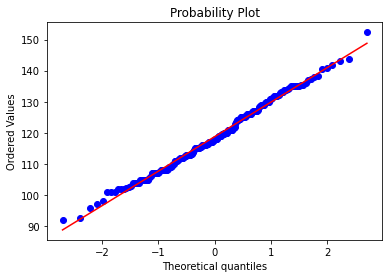

In [10]:
print(stats.shapiro(num_recruited))
stats.probplot(num_recruited, plot=plt);

The Shapiro-Wilk test doesn't indicate that it is normal,
but the probability plot and the histograms seem still quite normal.